In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns

In [2]:
df = pd.read_csv('merge_data.csv')

In [4]:
df.country.value_counts()

Czech Republic    706338
Slovakia          357633
Hungary           285599
Romania           276237
Germany           122474
Spain             119033
France             72947
Italy              41398
Croatia            37030
com                34392
Ireland            16575
Denmark            14006
Netherlands        10862
Austria            10734
Sweden              7594
Portugal            4918
Poland              4323
Belgium             3392
Finland             1599
Slovenia             713
United Kingdom        14
Bulgaria               6
Name: country, dtype: int64

In [3]:
df.isnull().sum()

Unnamed: 0                  0
order_id                    0
date                        0
payment                     0
item_code                   0
quantity                    0
unit_price_vat_excl         0
unit_cogs                   0
unit_rrp_vat_excl           0
department                  0
channel                     0
owner                       0
site                        0
CreatedAt                   0
store_ca                    0
location                   46
country                    46
days_of_week                0
month                       0
days                        0
sales                       0
item_name              839482
style                  839482
brand_id               839482
name                   839482
group0_id              839482
group0                 839482
group1_id              839482
group1                 839482
group2_id              839482
category               839482
gender                 839482
age                    839482
color     

In [7]:
df_country=df.loc[df['country'] == "Czech Republic"]

In [9]:
df_country.country.value_counts()
df_country.shape

(706338, 35)

In [12]:
df_country_features=df_country.sort_values('date').groupby(['date','country', 'unit_price_vat_excl', 'unit_cogs'], as_index=False)
df_country_features=df_country_features.agg({'quantity':['sum'], 'sales':['sum']})
df_country_features.columns=['date', 'country', 'unit_price_vat_excl', 'unit_cogs', 'quantity', 'sales']
df_country_features.head()

,date,country,unit_price_vat_excl,unit_cogs,quantity,sales
0,2019-06-01,Czech Republic,0.929070,0.0,14,13.006976
1,2019-06-01,Czech Republic,1.569767,0.0,7,10.988372
2,2019-06-01,Czech Republic,2.210078,0.0,5,11.050388
3,2019-06-01,Czech Republic,2.850775,0.0,1,2.850775
4,2019-06-01,Czech Republic,3.203101,0.0,-6,-19.218604


In [13]:
df_country_features.quantity.sum()

726357

In [14]:
df_country_features['cost']=df_country_features['unit_cogs']*df_country_features['quantity']
df_country_features['profit']=df_country_features['sales']-df_country_features['cost']

/var/folders/p7/8dgs9p213n5g4cwfv5162vnm0000gn/T/ipykernel_29652/3744617701.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_country_features.corr()))
/var/folders/p7/8dgs9p213n5g4cwfv5162vnm0000gn/T/ipykernel_29652/3744617701.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sb.heatmap(df_country_features.corr(), cmap="YlGnBu", annot=True, mask=mask)


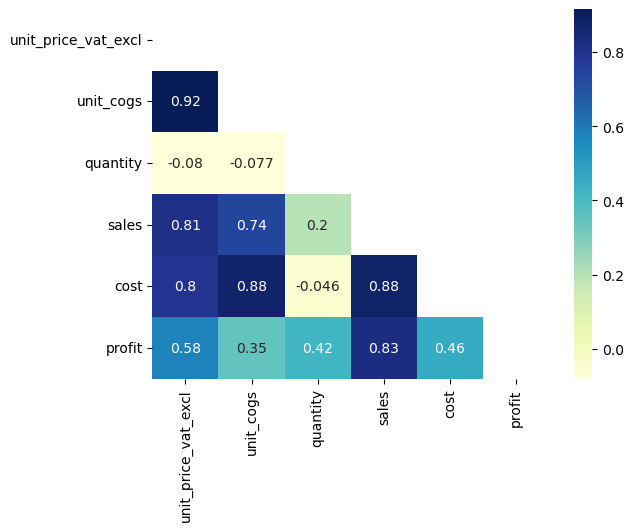

In [16]:
mask = np.triu(np.ones_like(df_country_features.corr()))
# plotting a triangle correlation heatmap
dataplot = sb.heatmap(df_country_features.corr(), cmap="YlGnBu", annot=True, mask=mask)
 
# displaying heatmap
mp.show()

In [17]:
df_f= df_country_features[['date', 'quantity', 'sales', 'cost', 'profit']]
df_final = df_f.groupby(['date']).sum()

In [18]:
df_final.shape

(957, 4)

In [19]:
df_final.isnull().sum()

quantity    0
sales       0
cost        0
profit      0
dtype: int64

In [27]:
#LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler

In [21]:
df_final.reset_index(inplace=True)
df_final

,date,quantity,sales,cost,profit
0,2019-06-01,85,2251.585654,1240.942248,1010.643406
1,2019-06-02,2,40.137597,27.658140,12.479457
2,2019-06-03,24,1075.567829,702.260465,373.307363
3,2019-06-04,1134,23619.969707,12977.891085,10642.078622
4,2019-06-05,1499,35163.149919,8910.189922,26252.959997
...,...,...,...,...,...
952,2022-01-10,913,22547.508862,13491.708915,9055.799947
953,2022-01-11,919,23273.353435,14318.000000,8955.353435
954,2022-01-12,909,21419.880954,12807.407364,8612.473589
955,2022-01-13,870,22808.812739,13694.887209,9113.925530


In [22]:
train_dates=pd.to_datetime(df_final['date'])
train_dates

0     2019-06-01
1     2019-06-02
2     2019-06-03
3     2019-06-04
4     2019-06-05
         ...    
952   2022-01-10
953   2022-01-11
954   2022-01-12
955   2022-01-13
956   2022-01-14
Name: date, Length: 957, dtype: datetime64[ns]

In [23]:
cols=list(df_final)[1:5]
cols

['quantity', 'sales', 'cost', 'profit']

In [24]:
df_for_training=df_final[cols].astype(float)

<AxesSubplot:>

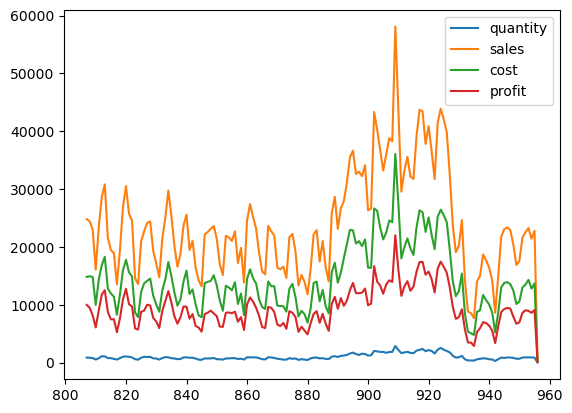

In [25]:
df_for_plot=df_for_training.tail(150)
df_for_plot.plot.line()

In [28]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [29]:
trainX = []
trainY = []

n_feature=1
n_past=14

for i in range(n_past, len(df_for_training_scaled)-n_feature+1):
    trainX.append(df_for_training_scaled[i-n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_feature-1:i+n_feature, 0])

trainX, trainY=np.array(trainX), np.array(trainY)

In [30]:
print('trainX shape=={}'.format(trainX.shape))
print('trainY shape=={}'.format(trainY.shape))

trainX shape==(943, 14, 4)
trainY shape==(943, 1)


In [31]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary

2022-12-05 13:46:51.930432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fc2fc4af6d0>>

In [32]:
history = model.fit(trainX, trainY, epochs=200, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/200
53/53 [==============================] - 4s 21ms/step - loss: 0.4532 - val_loss: 1.4573
Epoch 2/200
53/53 [==============================] - 1s 12ms/step - loss: 0.3363 - val_loss: 0.6339
Epoch 3/200
53/53 [==============================] - 1s 13ms/step - loss: 0.3307 - val_loss: 0.6800
Epoch 4/200
53/53 [==============================] - 1s 11ms/step - loss: 0.3070 - val_loss: 0.7049
Epoch 5/200
53/53 [==============================] - 1s 12ms/step - loss: 0.2510 - val_loss: 0.7369
Epoch 6/200
53/53 [==============================] - 1s 10ms/step - loss: 0.2472 - val_loss: 0.5160
Epoch 7/200
53/53 [==============================] - 1s 10ms/step - loss: 0.2371 - val_loss: 0.5708
Epoch 8/200
53/53 [==============================] - 1s 12ms/step - loss: 0.2458 - val_loss: 0.5355
Epoch 9/200
53/53 [==============================] - 1s 15ms/step - loss: 0.2275 - val_loss: 0.4964
Epoch 10/200
53/53 [==============================] - 1s 16ms/step - loss: 0.2312 - val_loss: 0.8375

53/53 [==============================] - 1s 10ms/step - loss: 0.1114 - val_loss: 0.5408
Epoch 83/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0980 - val_loss: 0.5055
Epoch 84/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0950 - val_loss: 0.5538
Epoch 85/200
53/53 [==============================] - 1s 12ms/step - loss: 0.0982 - val_loss: 0.5124
Epoch 86/200
53/53 [==============================] - 1s 12ms/step - loss: 0.1022 - val_loss: 0.5676
Epoch 87/200
53/53 [==============================] - 1s 12ms/step - loss: 0.1086 - val_loss: 0.4649
Epoch 88/200
53/53 [==============================] - 1s 10ms/step - loss: 0.1302 - val_loss: 0.4256
Epoch 89/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0951 - val_loss: 0.5068
Epoch 90/200
53/53 [==============================] - 1s 10ms/step - loss: 0.1021 - val_loss: 0.7630
Epoch 91/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0992 - val_loss: 0.5102
Epo

53/53 [==============================] - 1s 10ms/step - loss: 0.0624 - val_loss: 0.6648
Epoch 163/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0644 - val_loss: 0.6910
Epoch 164/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0649 - val_loss: 0.6695
Epoch 165/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0581 - val_loss: 0.6262
Epoch 166/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0632 - val_loss: 0.7651
Epoch 167/200
53/53 [==============================] - 1s 11ms/step - loss: 0.0687 - val_loss: 0.6560
Epoch 168/200
53/53 [==============================] - 1s 12ms/step - loss: 0.0646 - val_loss: 0.7042
Epoch 169/200
53/53 [==============================] - 1s 12ms/step - loss: 0.0608 - val_loss: 0.7397
Epoch 170/200
53/53 [==============================] - 1s 11ms/step - loss: 0.0579 - val_loss: 0.6449
Epoch 171/200
53/53 [==============================] - 1s 12ms/step - loss: 0.0715 - val_loss: 0

In [41]:
n_future=365
forecast_period_dates=pd.date_range(list(train_dates)[-1], periods=n_future, freq='D').tolist()

In [42]:
forecast = model.predict(trainX[-n_future:])
forecast_copies=np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

12/12 [==============================] - 0s 6ms/step


In [43]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [44]:
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'quantity':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

In [45]:
original = df_final[['date', 'quantity']]
original['date']=pd.to_datetime(original['date'])

/var/folders/p7/8dgs9p213n5g4cwfv5162vnm0000gn/T/ipykernel_29652/604500717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='quantity'>

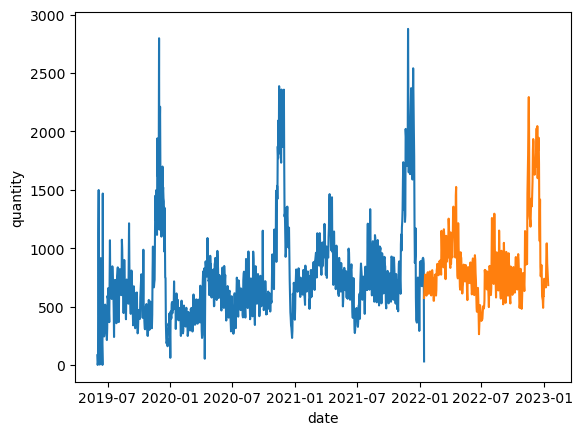

In [46]:
sns.lineplot(original['date'], original['quantity'])
sns.lineplot(df_forecast['date'], df_forecast['quantity'])

In [48]:
df_forecast.round(0)

,date,quantity
0,2022-01-14,575.0
1,2022-01-15,648.0
2,2022-01-16,735.0
3,2022-01-17,775.0
4,2022-01-18,761.0
...,...,...
360,2023-01-09,1043.0
361,2023-01-10,870.0
362,2023-01-11,812.0
363,2023-01-12,748.0


In [49]:
#CNN 
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Flatten

In [50]:
model_cnn = Sequential()
model_cnn.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))

model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fc2f271acd0>>

In [51]:
history_cnn = model_cnn.fit(trainX, trainY, epochs=200, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/200
53/53 [==============================] - 1s 7ms/step - loss: 0.2830 - val_loss: 0.7387
Epoch 2/200
53/53 [==============================] - 0s 6ms/step - loss: 0.2150 - val_loss: 0.7904
Epoch 3/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1830 - val_loss: 0.9854
Epoch 4/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1944 - val_loss: 0.6569
Epoch 5/200
53/53 [==============================] - 0s 2ms/step - loss: 0.1653 - val_loss: 0.6769
Epoch 6/200
53/53 [==============================] - 0s 3ms/step - loss: 0.1623 - val_loss: 1.0167
Epoch 7/200
53/53 [==============================] - 0s 5ms/step - loss: 0.1437 - val_loss: 0.6968
Epoch 8/200
53/53 [==============================] - 0s 4ms/step - loss: 0.1470 - val_loss: 0.8233
Epoch 9/200
53/53 [==============================] - 0s 4ms/step - loss: 0.1388 - val_loss: 0.6295
Epoch 10/200
53/53 [==============================] - 0s 4ms/step - loss: 0.1280 - val_loss: 0.6642
Epoch 11/

Epoch 83/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0220 - val_loss: 0.6940
Epoch 84/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0187 - val_loss: 0.6391
Epoch 85/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0202 - val_loss: 0.6081
Epoch 86/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0235 - val_loss: 0.6877
Epoch 87/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0187 - val_loss: 0.5851
Epoch 88/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0198 - val_loss: 0.7499
Epoch 89/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0197 - val_loss: 0.5859
Epoch 90/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0175 - val_loss: 0.6922
Epoch 91/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0207 - val_loss: 0.7066
Epoch 92/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0212 - val_loss: 0.6738


53/53 [==============================] - 0s 3ms/step - loss: 0.0116 - val_loss: 0.6881
Epoch 165/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.6673
Epoch 166/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss: 0.5612
Epoch 167/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0119 - val_loss: 0.6247
Epoch 168/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.7360
Epoch 169/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.6306
Epoch 170/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.7869
Epoch 171/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0124 - val_loss: 0.7544
Epoch 172/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.5997
Epoch 173/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.6179
Epoc

12/12 [==============================] - 0s 2ms/step


/var/folders/p7/8dgs9p213n5g4cwfv5162vnm0000gn/T/ipykernel_29652/1622307858.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an expli

<AxesSubplot:xlabel='date', ylabel='quantity'>

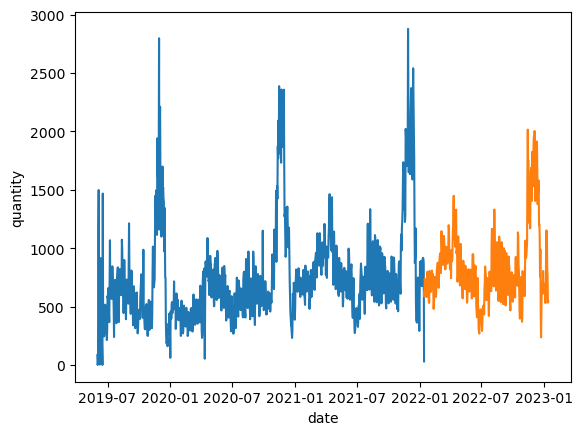

In [52]:
n_future=365
forecast_period_dates=pd.date_range(list(train_dates)[-1], periods=n_future, freq='D').tolist()

forecast = model_cnn.predict(trainX[-n_future:])

forecast_copies=np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'quantity':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

original = df_final[['date', 'quantity']]
original['date']=pd.to_datetime(original['date'])

sns.lineplot(original['date'], original['quantity'])
sns.lineplot(df_forecast['date'], df_forecast['quantity'])

In [53]:
df_forecast.round(0)

,date,quantity
0,2022-01-14,626.0
1,2022-01-15,586.0
2,2022-01-16,739.0
3,2022-01-17,722.0
4,2022-01-18,681.0
...,...,...
360,2023-01-09,1149.0
361,2023-01-10,839.0
362,2023-01-11,764.0
363,2023-01-12,535.0
